In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

os.chdir('/home/mattho/git/ltu-cmass/notebooks')

0.6056622 23765.723
0.009763996 317.983
5.2189426 264.03848
8.20555 nan


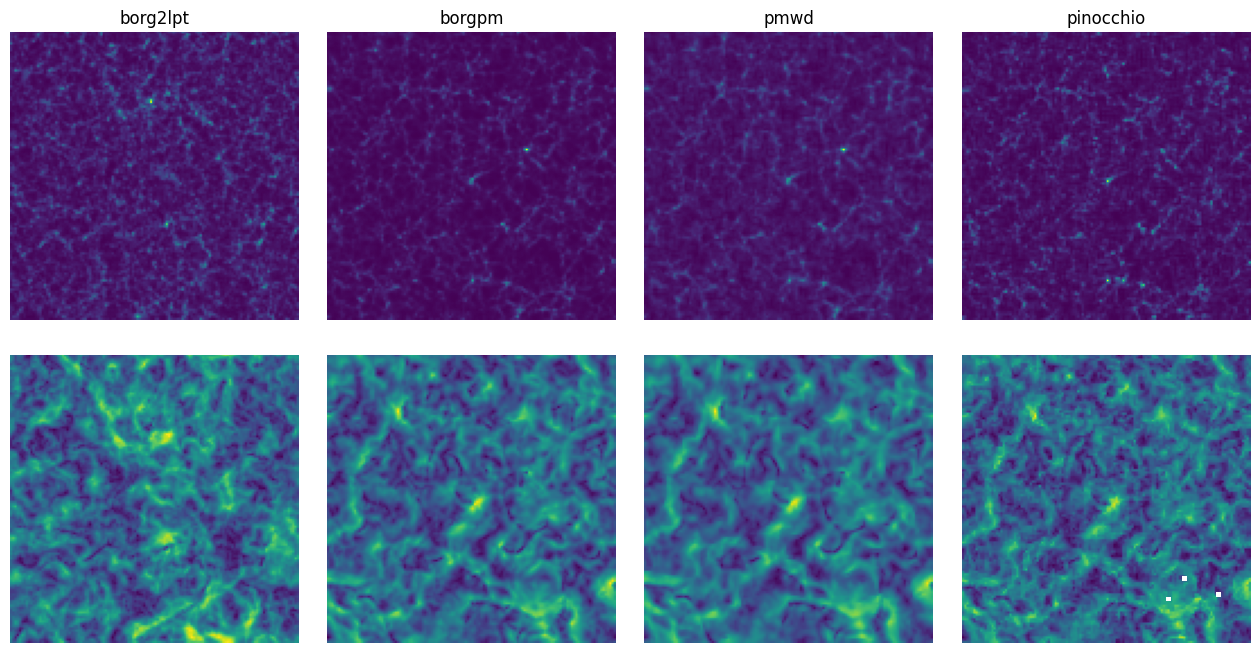

In [2]:
# temp
mlist = ['borg2lpt', 'borgpm', 'pmwd', 'pinocchio']

f, axs = plt.subplots(
    2,len(mlist), figsize=(4*len(mlist),8), 
    gridspec_kw=dict(hspace=0.1, wspace=0.1)
)

for i, m in enumerate(mlist):
    path = f"/home/mattho/git/ltu-cmass/data/test/{m}/L1000-N128/100"

    rho = np.load(join(path, 'rho.npy'))
    fvel = np.load(join(path, 'fvel.npy'))
    print(rho.std(), fvel.std())

    ax = axs[0,i]
    ax.imshow(rho[0])
    ax.axis('off')
    ax.set_title(m)

    ax = axs[1,i]
    ax.imshow(np.linalg.norm(fvel[0], axis=-1))
    ax.axis('off')


## Suite

In [3]:
from collections import Counter
suitepath = '/home/mattho/git/ltu-cmass/data/charm_1gpch_z0.5/borgpm/L1000-N128/'

c = Counter()
for r in tqdm(os.listdir(suitepath)):
    for k in os.listdir(join(suitepath, r)):
        c[k] += 1
c

  4%|▍         | 84/2000 [00:00<00:02, 783.87it/s]

 64%|██████▎   | 1270/2000 [00:01<00:00, 885.07it/s]


KeyboardInterrupt: 

In [ ]:
cosmofile = '../params/latin_hypercube_params.txt'
cosmos = pd.read_csv(cosmofile, sep=' ', header=None).values
cosmos

array([[0.1755 , 0.06681, 0.7737 , 0.8849 , 0.6641 ],
       [0.2139 , 0.05557, 0.8599 , 0.9785 , 0.8619 ],
       [0.1867 , 0.04503, 0.6189 , 0.8307 , 0.7187 ],
       ...,
       [0.4017 , 0.04425, 0.8509 , 0.8251 , 0.7833 ],
       [0.2953 , 0.04701, 0.8017 , 0.8193 , 0.6627 ],
       [0.3175 , 0.049  , 0.6711 , 0.9624 , 0.834  ]])

In [ ]:
# Load Pks
pks = np.zeros((len(cosmos), 399))
for r in tqdm(os.listdir(suitepath)):
    try:
        pk = np.load(join(suitepath, r, 'Pk', 'Pk0.npz'))
    except FileNotFoundError:
        continue
    k_gal = pk['k_gal']
    p0 = pk['p0k_gal']
    pks[int(r)] = p0

100%|██████████| 2000/2000 [00:01<00:00, 1731.36it/s]


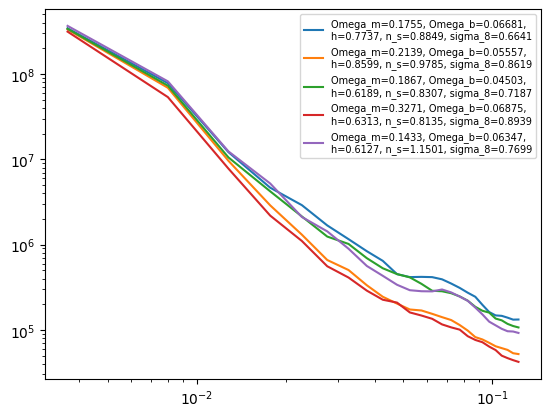

In [ ]:
plt.loglog()

for i in range(5):
    lstr = f"Omega_m={cosmos[i,0]}, Omega_b={cosmos[i,1]}, \n"
    lstr += f"h={cosmos[i,2]}, n_s={cosmos[i,3]}, sigma_8={cosmos[i,4]}"
    plt.plot(k_gal, pks[i], label=lstr)
plt.legend(fontsize=7)

## Inference

In [4]:
mask = np.all(pks==0, axis=1)
pks = pks[~mask]
cosmos = cosmos[~mask]

x = np.log10(pks[:2000,:25])
theta = cosmos[:2000]

NameError: name 'pks' is not defined

In [ ]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
device='cpu'

In [ ]:
loader = NumpyLoader(x=x, theta=theta)

# define a prior
prior = ili.utils.Uniform(
    low=theta.min(axis=0),
    high=theta.max(axis=0),
    device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_lampe(model='nsf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_lampe(model='gf', hidden_features=50, num_transforms=5)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args
)

In [ ]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
244 epochs [02:47,  1.46 epochs/s, loss=-13.1, loss_val=-12]  
INFO:root:Training model 2 / 2.
271 epochs [02:30,  1.81 epochs/s, loss=-12.4, loss_val=-11.6]
INFO:root:It took 317.7501962184906 seconds to train models.


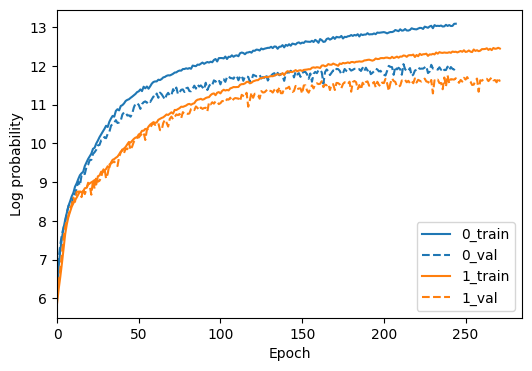

In [15]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = [f"C{i}" for i in range(len(summaries))]
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

INFO:root:Sampling models with tensor([572., 428.]) samples each.
Drawing 572 posterior samples: 1109it [00:00, 6174.46it/s]                        
Drawing 428 posterior samples: 778it [00:00, 14247.72it/s]            


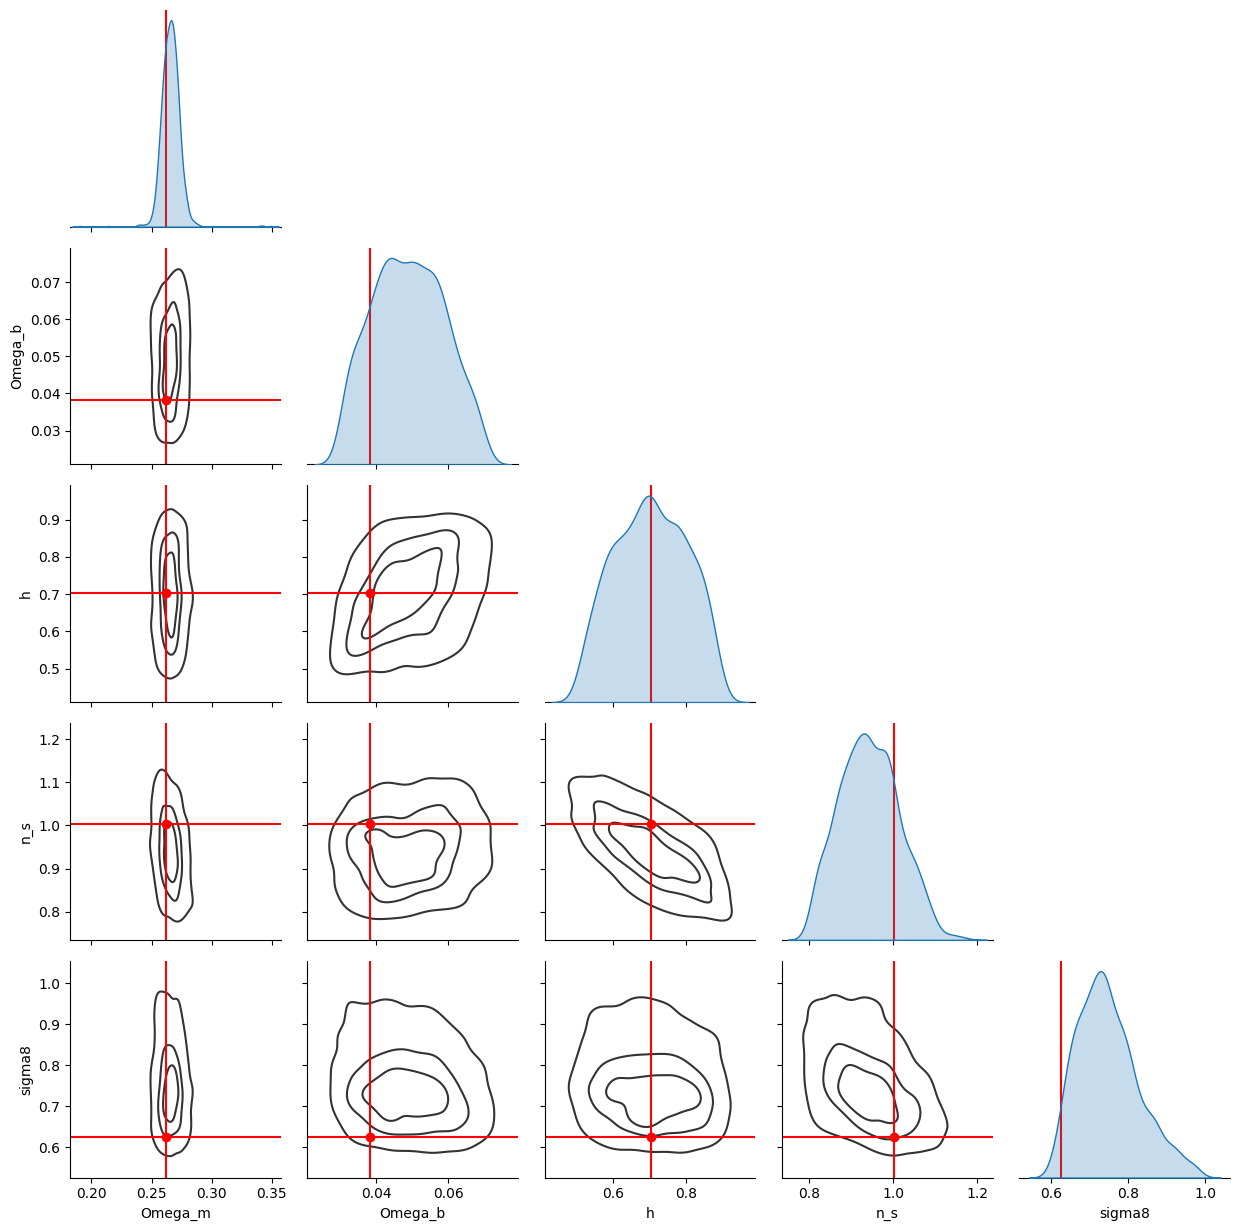

In [16]:
# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
    # labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind]
)

100%|██████████| 1999/1999 [06:07<00:00,  5.44it/s] 
INFO:root:Mean logprob: 1.2509e+01Median logprob: 1.2591e+01
100%|██████████| 100/100 [00:13<00:00,  7.24it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


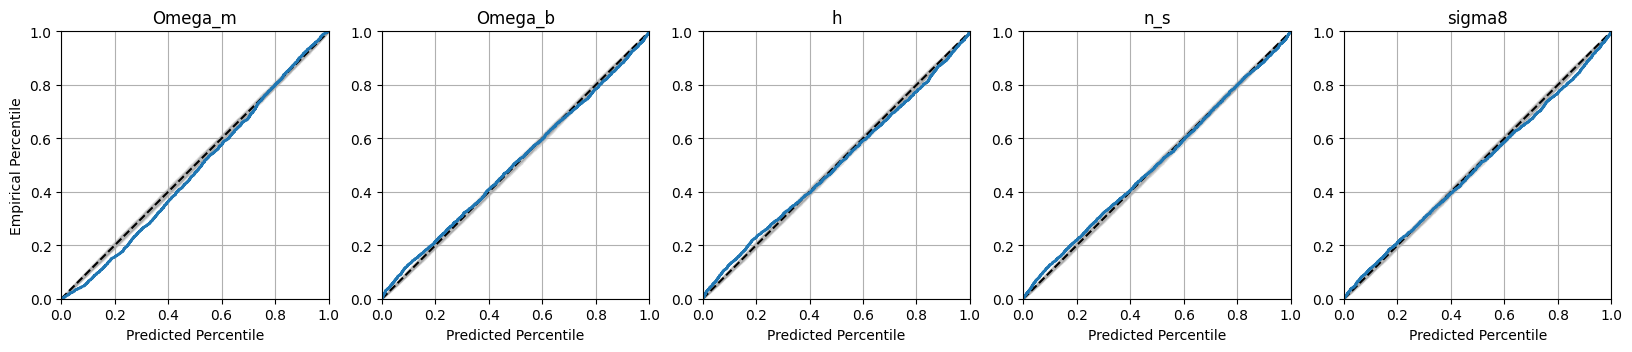

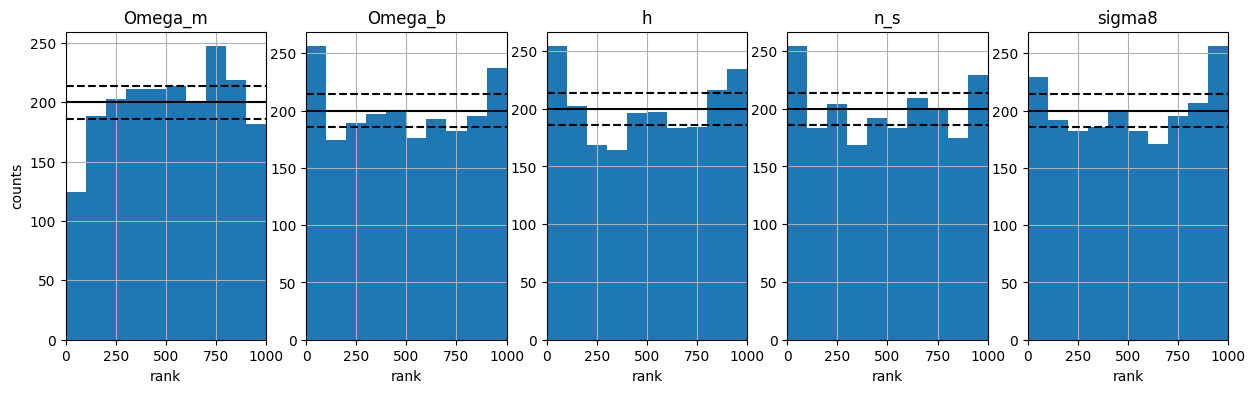

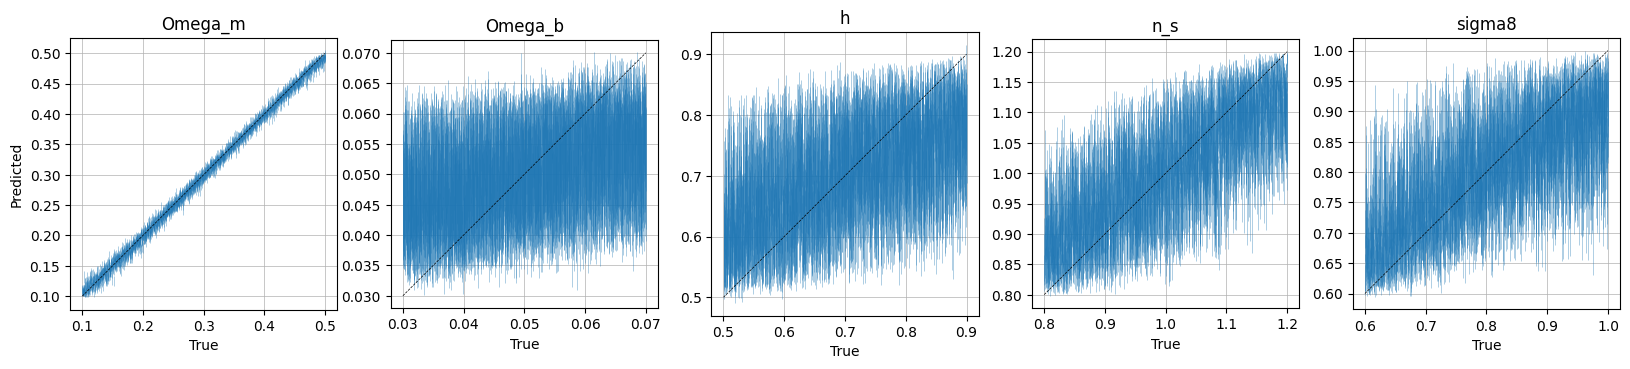

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


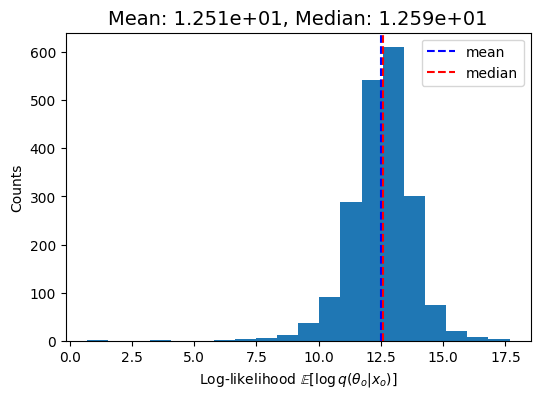

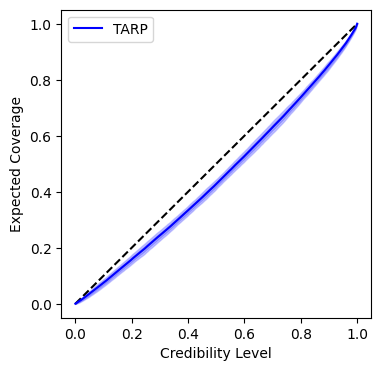

In [17]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

## Compare suite on every level

In [2]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import MAS_library as MASL
import Pk_library as PKL
import redshift_space_library as RSL
from omegaconf import OmegaConf
import h5py

os.chdir('/home/mattho/git/ltu-cmass/matts_tests')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def Pk3D(x, L=1000, MAS='None', axis=0, threads=16):
    # handle multiple x's
    if len(x.shape) == 4:
        results = [Pk3D(xi, L, MAS, axis, threads) for xi in x]
        k, Pk = list(zip(*results))
        return np.array(k), np.array(Pk)

    Pk = PKL.Pk(x.astype(np.float32),
                L, axis, MAS, threads, verbose=0)
    return Pk.k1D, Pk.Pk1D

In [4]:
from collections import Counter
suitepath = '/home/mattho/git/ltu-cmass/data/2gpch_0704/borgpm/L2000-N256/'

c = Counter()
for r in tqdm(os.listdir(suitepath)):
    for k in os.listdir(join(suitepath, r)):
        c[k] += 1
c

100%|██████████| 1001/1001 [00:03<00:00, 273.29it/s]


Counter({'rho_transfer.npy': 1000,
         'rho.npy': 932,
         'fvel.npy': 932,
         'config.yaml': 932,
         'halo_pos.npy': 931,
         'halo_vel.npy': 931,
         'halo_mass.npy': 931,
         'hod': 931,
         'obs': 930,
         'diag': 704})

In [5]:
cosmofile = '../params/latin_hypercube_params.txt'
cosmos = pd.read_csv(cosmofile, sep=' ', header=None).values

Nsims = len(cosmos)
mask = np.ones(Nsims, dtype=bool)
mask[-1] = False

In [6]:
# Measure rho power spectra
rho_pk = []
# for p in tqdm(range(Nsims)):
#     try:
#         rho = np.load(join(suitepath, str(p), 'rho.npy'))
#         cfg = OmegaConf.load(join(suitepath, str(p), 'config.yaml'))
#     except FileNotFoundError:
#         print(f"Skipping {p}.")
#         mask[int(p)] = False
#         rho_pk.append(_Pk)
#         continue
#     N = cfg.nbody.N
#     L = cfg.nbody.L
    
#     k, _Pk = Pk3D(rho, L=L, MAS='CIC', threads=20)
#     rho_pk.append(_Pk)
for p in tqdm(range(Nsims)):
    try:
        filename = join(suitepath, str(p), 'diag', 'rho.h5')
        with h5py.File(filename, 'r') as f:
            k = f['k'][:]
            _Pk = f['Pk'][:,0]
        rho_pk.append(_Pk)
    except FileNotFoundError:
        print(f"Skipping {p}.")
        mask[int(p)] = False
        rho_pk.append(_Pk)
        continue
        

  2%|▏         | 35/2001 [00:00<00:05, 343.23it/s]

Skipping 8.
Skipping 18.
Skipping 22.
Skipping 42.
Skipping 59.


  3%|▎         | 70/2001 [00:00<00:05, 322.40it/s]

Skipping 71.


  5%|▌         | 109/2001 [00:00<00:05, 349.43it/s]

Skipping 95.
Skipping 103.
Skipping 118.


  7%|▋         | 145/2001 [00:00<00:05, 351.48it/s]

Skipping 146.
Skipping 150.
Skipping 164.


 11%|█         | 220/2001 [00:00<00:04, 363.40it/s]

Skipping 180.
Skipping 188.
Skipping 207.
Skipping 212.
Skipping 237.
Skipping 252.
Skipping 256.


 15%|█▍        | 297/2001 [00:00<00:04, 372.30it/s]

Skipping 261.
Skipping 286.
Skipping 290.
Skipping 312.


 17%|█▋        | 335/2001 [00:00<00:04, 370.72it/s]

Skipping 324.
Skipping 328.
Skipping 329.


 19%|█▊        | 373/2001 [00:01<00:04, 367.72it/s]

Skipping 349.
Skipping 360.
Skipping 370.


 20%|██        | 410/2001 [00:01<00:07, 225.79it/s]

Skipping 414.
Skipping 418.
Skipping 426.


 24%|██▍       | 479/2001 [00:02<00:17, 88.78it/s] 

Skipping 472.
Skipping 477.
Skipping 487.


 26%|██▌       | 515/2001 [00:03<00:19, 75.74it/s]

Skipping 506.
Skipping 512.
Skipping 514.
Skipping 515.


 28%|██▊       | 563/2001 [00:03<00:12, 116.53it/s]

Skipping 530.
Skipping 563.


 32%|███▏      | 637/2001 [00:03<00:06, 219.81it/s]

Skipping 587.
Skipping 590.
Skipping 592.
Skipping 595.
Skipping 612.
Skipping 619.
Skipping 635.
Skipping 637.
Skipping 647.


 41%|████      | 820/2001 [00:03<00:02, 573.79it/s]

Skipping 675.
Skipping 704.
Skipping 705.
Skipping 706.
Skipping 707.
Skipping 708.
Skipping 709.
Skipping 710.
Skipping 711.
Skipping 712.
Skipping 713.
Skipping 714.
Skipping 715.
Skipping 716.
Skipping 717.
Skipping 718.
Skipping 719.
Skipping 720.
Skipping 721.
Skipping 722.
Skipping 723.
Skipping 724.
Skipping 725.
Skipping 726.
Skipping 727.
Skipping 728.
Skipping 729.
Skipping 730.
Skipping 731.
Skipping 732.
Skipping 733.
Skipping 734.
Skipping 735.
Skipping 736.
Skipping 737.
Skipping 738.
Skipping 739.
Skipping 740.
Skipping 741.
Skipping 742.
Skipping 743.
Skipping 744.
Skipping 745.
Skipping 746.
Skipping 747.
Skipping 748.
Skipping 749.
Skipping 750.
Skipping 751.
Skipping 752.
Skipping 753.
Skipping 754.
Skipping 755.
Skipping 756.
Skipping 757.
Skipping 758.
Skipping 759.
Skipping 760.
Skipping 761.
Skipping 762.
Skipping 763.
Skipping 764.
Skipping 765.
Skipping 766.
Skipping 767.
Skipping 768.
Skipping 769.
Skipping 770.
Skipping 771.
Skipping 772.
Skipping 773.
Skippi

 97%|█████████▋| 1939/2001 [00:04<00:00, 2490.85it/s]

Skipping 1261.
Skipping 1262.
Skipping 1263.
Skipping 1264.
Skipping 1265.
Skipping 1266.
Skipping 1267.
Skipping 1268.
Skipping 1269.
Skipping 1270.
Skipping 1271.
Skipping 1272.
Skipping 1273.
Skipping 1274.
Skipping 1275.
Skipping 1276.
Skipping 1277.
Skipping 1278.
Skipping 1279.
Skipping 1280.
Skipping 1281.
Skipping 1282.
Skipping 1283.
Skipping 1284.
Skipping 1285.
Skipping 1286.
Skipping 1287.
Skipping 1288.
Skipping 1289.
Skipping 1290.
Skipping 1291.
Skipping 1292.
Skipping 1293.
Skipping 1294.
Skipping 1295.
Skipping 1296.
Skipping 1297.
Skipping 1298.
Skipping 1299.
Skipping 1300.
Skipping 1301.
Skipping 1302.
Skipping 1303.
Skipping 1304.
Skipping 1305.
Skipping 1306.
Skipping 1307.
Skipping 1308.
Skipping 1309.
Skipping 1310.
Skipping 1311.
Skipping 1312.
Skipping 1313.
Skipping 1314.
Skipping 1315.
Skipping 1316.
Skipping 1317.
Skipping 1318.
Skipping 1319.
Skipping 1320.
Skipping 1321.
Skipping 1322.
Skipping 1323.
Skipping 1324.
Skipping 1325.
Skipping 1326.
Skipping 1

100%|██████████| 2001/2001 [00:04<00:00, 471.37it/s] 

Skipping 1952.
Skipping 1953.
Skipping 1954.
Skipping 1955.
Skipping 1956.
Skipping 1957.
Skipping 1958.
Skipping 1959.
Skipping 1960.
Skipping 1961.
Skipping 1962.
Skipping 1963.
Skipping 1964.
Skipping 1965.
Skipping 1966.
Skipping 1967.
Skipping 1968.
Skipping 1969.
Skipping 1970.
Skipping 1971.
Skipping 1972.
Skipping 1973.
Skipping 1974.
Skipping 1975.
Skipping 1976.
Skipping 1977.
Skipping 1978.
Skipping 1979.
Skipping 1980.
Skipping 1981.
Skipping 1982.
Skipping 1983.
Skipping 1984.
Skipping 1985.
Skipping 1986.
Skipping 1987.
Skipping 1988.
Skipping 1989.
Skipping 1990.
Skipping 1991.
Skipping 1992.
Skipping 1993.
Skipping 1994.
Skipping 1995.
Skipping 1996.
Skipping 1997.
Skipping 1998.
Skipping 1999.
Skipping 2000.


In [7]:
# Measure halo power spectra

halo_pk = []
for p in tqdm(range(Nsims)):
    try:
        filename = join(suitepath, str(p), 'diag', 'halo.h5')
        with h5py.File(filename, 'r') as f:
            k = f['Pk']['k'][:]
            _Pk = f['Pk']['Pk'][:,0]
        halo_pk.append(_Pk)
    except FileNotFoundError:
        print(f"Skipping {p}.")
        mask[int(p)] = False
        halo_pk.append(_Pk)
        continue
    

# MAS = 'NGP'
# halo_pk = []
# for p in tqdm(range(Nsims)):
#     try:
#         hpos = np.load(join(suitepath, str(p), 'halo_pos.npy'))
#         cfg = OmegaConf.load(join(suitepath, str(p), 'config.yaml'))
#     except FileNotFoundError:
#         print(f"Skipping {p}.")
#         mask[int(p)] = False
#         halo_pk.append(_Pk)
#         continue
#     N = cfg.nbody.N
#     L = cfg.nbody.L

#     delta = np.empty((N,N,N), dtype=np.float32)
#     MASL.MA(hpos.astype(np.float32), delta, L, MAS=MAS, verbose=0)
#     delta /= delta.mean()
#     delta -= 1
    
#     k, _Pk = Pk3D(delta, L=L, MAS=MAS, threads=32)
#     halo_pk.append(_Pk)

  4%|▍         | 83/2001 [00:00<00:04, 407.44it/s]

Skipping 8.
Skipping 18.
Skipping 22.
Skipping 42.
Skipping 59.
Skipping 71.


  8%|▊         | 163/2001 [00:00<00:04, 371.94it/s]

Skipping 95.
Skipping 103.
Skipping 118.
Skipping 146.
Skipping 150.
Skipping 164.


 12%|█▏        | 241/2001 [00:00<00:04, 380.77it/s]

Skipping 180.
Skipping 188.
Skipping 207.
Skipping 212.
Skipping 237.
Skipping 252.
Skipping 256.


 17%|█▋        | 332/2001 [00:00<00:03, 420.67it/s]

Skipping 261.
Skipping 286.
Skipping 290.
Skipping 312.
Skipping 324.
Skipping 328.
Skipping 329.
Skipping 349.


 21%|██        | 417/2001 [00:01<00:03, 406.55it/s]

Skipping 360.
Skipping 370.
Skipping 414.
Skipping 418.
Skipping 426.


 27%|██▋       | 550/2001 [00:01<00:03, 431.88it/s]

Skipping 472.
Skipping 477.
Skipping 487.
Skipping 506.
Skipping 512.
Skipping 514.
Skipping 515.
Skipping 530.
Skipping 563.


 32%|███▏      | 642/2001 [00:01<00:03, 445.26it/s]

Skipping 587.
Skipping 590.
Skipping 592.
Skipping 595.
Skipping 612.
Skipping 619.
Skipping 635.
Skipping 637.
Skipping 647.


100%|██████████| 2001/2001 [00:01<00:00, 1115.22it/s]

Skipping 675.
Skipping 705.
Skipping 706.
Skipping 707.
Skipping 708.
Skipping 709.
Skipping 710.
Skipping 711.
Skipping 712.
Skipping 713.
Skipping 714.
Skipping 715.
Skipping 716.
Skipping 717.
Skipping 718.
Skipping 719.
Skipping 720.
Skipping 721.
Skipping 722.
Skipping 723.
Skipping 724.
Skipping 725.
Skipping 726.
Skipping 727.
Skipping 728.
Skipping 729.
Skipping 730.
Skipping 731.
Skipping 732.
Skipping 733.
Skipping 734.
Skipping 735.
Skipping 736.
Skipping 737.
Skipping 738.
Skipping 739.
Skipping 740.
Skipping 741.
Skipping 742.
Skipping 743.
Skipping 744.
Skipping 745.
Skipping 746.
Skipping 747.
Skipping 748.
Skipping 749.
Skipping 750.
Skipping 751.
Skipping 752.
Skipping 753.
Skipping 754.
Skipping 755.
Skipping 756.
Skipping 757.
Skipping 758.
Skipping 759.
Skipping 760.
Skipping 761.
Skipping 762.
Skipping 763.
Skipping 764.
Skipping 765.
Skipping 766.
Skipping 767.
Skipping 768.
Skipping 769.
Skipping 770.
Skipping 771.
Skipping 772.
Skipping 773.
Skipping 774.
Skippi

In [8]:
# Measure halo power spectra in redshift space

haloz_pk = []
for p in tqdm(range(Nsims)):
    try:
        filename = join(suitepath, str(p), 'diag', 'halo.h5')
        with h5py.File(filename, 'r') as f:
            k = f['zPk']['k'][:]
            _Pk = f['zPk']['Pk'][:,0]
        haloz_pk.append(_Pk)
    except FileNotFoundError:
        print(f"Skipping {p}.")
        mask[int(p)] = False
        haloz_pk.append(_Pk)
        continue

# MAS = 'NGP'
# haloz_pk = []
# for p in tqdm(range(Nsims)):
#     p = str(p)
#     try:
#         hpos = np.load(join(suitepath, p, 'halo_pos.npy'))
#         hvel = np.load(join(suitepath, p, 'halo_vel.npy'))
#         cfg = OmegaConf.load(join(suitepath, p, 'config.yaml'))
#     except FileNotFoundError:
#         print(f"Skipping {p}.")
#         mask[int(p)] = False
#         haloz_pk.append(_Pk)
#         continue
#     N = cfg.nbody.N
#     L = cfg.nbody.L
#     h = cfg.nbody.cosmo[2]

#     RSL.pos_redshift_space(hpos, hvel, L, Hubble=h*100, redshift=0.5, axis=0)

#     delta = np.empty((N,N,N), dtype=np.float32)
#     MASL.MA(hpos.astype(np.float32), delta, L, MAS=MAS, verbose=0)
#     delta /= delta.mean()
#     delta -= 1
    
#     k, _Pk = Pk3D(delta, L=L, MAS=MAS, threads=32)
#     haloz_pk.append(_Pk)

  4%|▍         | 87/2001 [00:00<00:04, 431.38it/s]

Skipping 8.
Skipping 18.
Skipping 22.
Skipping 42.
Skipping 59.
Skipping 71.
Skipping 95.


  9%|▊         | 174/2001 [00:00<00:04, 404.68it/s]

Skipping 103.
Skipping 118.
Skipping 146.
Skipping 150.
Skipping 164.
Skipping 180.


 13%|█▎        | 256/2001 [00:00<00:04, 398.08it/s]

Skipping 188.
Skipping 207.
Skipping 212.
Skipping 237.
Skipping 252.
Skipping 256.
Skipping 261.


 18%|█▊        | 352/2001 [00:00<00:03, 439.20it/s]

Skipping 286.
Skipping 290.
Skipping 312.
Skipping 324.
Skipping 328.
Skipping 329.
Skipping 349.
Skipping 360.
Skipping 370.


 25%|██▍       | 496/2001 [00:01<00:03, 454.58it/s]

Skipping 414.
Skipping 418.
Skipping 426.
Skipping 472.
Skipping 477.
Skipping 487.
Skipping 506.
Skipping 512.
Skipping 514.
Skipping 515.


 30%|██▉       | 592/2001 [00:01<00:03, 435.11it/s]

Skipping 530.
Skipping 563.
Skipping 587.
Skipping 590.
Skipping 592.
Skipping 595.


 34%|███▍      | 678/2001 [00:01<00:03, 385.12it/s]

Skipping 612.
Skipping 619.
Skipping 635.
Skipping 637.
Skipping 647.
Skipping 675.


100%|██████████| 2001/2001 [00:01<00:00, 1126.57it/s]

Skipping 705.
Skipping 706.
Skipping 707.
Skipping 708.
Skipping 709.
Skipping 710.
Skipping 711.
Skipping 712.
Skipping 713.
Skipping 714.
Skipping 715.
Skipping 716.
Skipping 717.
Skipping 718.
Skipping 719.
Skipping 720.
Skipping 721.
Skipping 722.
Skipping 723.
Skipping 724.
Skipping 725.
Skipping 726.
Skipping 727.
Skipping 728.
Skipping 729.
Skipping 730.
Skipping 731.
Skipping 732.
Skipping 733.
Skipping 734.
Skipping 735.
Skipping 736.
Skipping 737.
Skipping 738.
Skipping 739.
Skipping 740.
Skipping 741.
Skipping 742.
Skipping 743.
Skipping 744.
Skipping 745.
Skipping 746.
Skipping 747.
Skipping 748.
Skipping 749.
Skipping 750.
Skipping 751.
Skipping 752.
Skipping 753.
Skipping 754.
Skipping 755.
Skipping 756.
Skipping 757.
Skipping 758.
Skipping 759.
Skipping 760.
Skipping 761.
Skipping 762.
Skipping 763.
Skipping 764.
Skipping 765.
Skipping 766.
Skipping 767.
Skipping 768.
Skipping 769.
Skipping 770.
Skipping 771.
Skipping 772.
Skipping 773.
Skipping 774.
Skipping 775.
Skippi

In [9]:
# Measure galaxy power spectra
hod = 0

gal_pk = []
for p in tqdm(range(Nsims)):
    try:
        filename = join(suitepath, str(p), 'diag', 'gal.h5')
        with h5py.File(filename, 'r') as f:
            k = f['Pk']['k'][:]
            _Pk = f['Pk']['Pk'][:,0]
        gal_pk.append(_Pk)
    except FileNotFoundError:
        print(f"Skipping {p}.")
        mask[int(p)] = False
        gal_pk.append(_Pk)
        continue


# MAS = 'NGP'
# gal_pk = []
# for p in tqdm(range(Nsims)):
#     p = str(p)
#     try:
#         gpos = np.load(join(suitepath, p, 'hod', f'hod{hod}_pos.npy'))
#         cfg = OmegaConf.load(join(suitepath, p, 'config.yaml'))
#     except FileNotFoundError:
#         print(f"Skipping {p}.")
#         mask[int(p)] = False
#         gal_pk.append(_Pk)
#         continue
#     N = cfg.nbody.N
#     L = cfg.nbody.L

#     delta = np.empty((N,N,N), dtype=np.float32)
#     MASL.MA(hpos.astype(np.float32), delta, L, MAS=MAS, verbose=0)
#     delta /= delta.mean()
#     delta -= 1
    
#     k, _Pk = Pk3D(delta, L=L, MAS=MAS, threads=16)
#     gal_pk.append(_Pk)

  0%|          | 0/2001 [00:00<?, ?it/s]

Skipping 8.
Skipping 18.
Skipping 22.


  5%|▌         | 106/2001 [00:00<00:03, 504.05it/s]

Skipping 42.
Skipping 59.
Skipping 71.
Skipping 95.
Skipping 103.
Skipping 118.


 10%|█         | 207/2001 [00:00<00:03, 481.56it/s]

Skipping 146.
Skipping 150.
Skipping 164.
Skipping 180.
Skipping 188.
Skipping 207.
Skipping 212.
Skipping 237.


 15%|█▌        | 304/2001 [00:00<00:03, 466.12it/s]

Skipping 252.
Skipping 256.
Skipping 261.
Skipping 286.
Skipping 290.
Skipping 312.
Skipping 324.
Skipping 328.
Skipping 329.


 20%|█▉        | 398/2001 [00:00<00:03, 461.10it/s]

Skipping 349.
Skipping 360.
Skipping 370.
Skipping 414.
Skipping 418.
Skipping 426.


 27%|██▋       | 541/2001 [00:01<00:03, 463.52it/s]

Skipping 472.
Skipping 477.
Skipping 487.
Skipping 506.
Skipping 512.
Skipping 514.
Skipping 515.
Skipping 530.


 32%|███▏      | 639/2001 [00:01<00:03, 452.60it/s]

Skipping 563.
Skipping 587.
Skipping 590.
Skipping 592.
Skipping 595.
Skipping 612.
Skipping 619.
Skipping 635.
Skipping 637.
Skipping 647.


100%|██████████| 2001/2001 [00:01<00:00, 1233.01it/s]

Skipping 675.
Skipping 705.
Skipping 706.
Skipping 707.
Skipping 708.
Skipping 709.
Skipping 710.
Skipping 711.
Skipping 712.
Skipping 713.
Skipping 714.
Skipping 715.
Skipping 716.
Skipping 717.
Skipping 718.
Skipping 719.
Skipping 720.
Skipping 721.
Skipping 722.
Skipping 723.
Skipping 724.
Skipping 725.
Skipping 726.
Skipping 727.
Skipping 728.
Skipping 729.
Skipping 730.
Skipping 731.
Skipping 732.
Skipping 733.
Skipping 734.
Skipping 735.
Skipping 736.
Skipping 737.
Skipping 738.
Skipping 739.
Skipping 740.
Skipping 741.
Skipping 742.
Skipping 743.
Skipping 744.
Skipping 745.
Skipping 746.
Skipping 747.
Skipping 748.
Skipping 749.
Skipping 750.
Skipping 751.
Skipping 752.
Skipping 753.
Skipping 754.
Skipping 755.
Skipping 756.
Skipping 757.
Skipping 758.
Skipping 759.
Skipping 760.
Skipping 761.
Skipping 762.
Skipping 763.
Skipping 764.
Skipping 765.
Skipping 766.
Skipping 767.
Skipping 768.
Skipping 769.
Skipping 770.
Skipping 771.
Skipping 772.
Skipping 773.
Skipping 774.
Skippi

In [10]:
# Measure galaxy power spectra in redshift space
hod = 0

galz_pk = []
for p in tqdm(range(Nsims)):
    try:
        filename = join(suitepath, str(p), 'diag', 'gal.h5')
        with h5py.File(filename, 'r') as f:
            k = f['zPk']['k'][:]
            _Pk = f['zPk']['Pk'][:,0]
        galz_pk.append(_Pk)
    except FileNotFoundError:
        print(f"Skipping {p}.")
        mask[int(p)] = False
        galz_pk.append(_Pk)
        continue

# MAS = 'NGP'
# galz_pk = []
# for p in tqdm(range(Nsims)):
#     p = str(p)
#     try:
#         gpos = np.load(join(suitepath, p, 'hod', f'hod{hod}_pos.npy')).copy(order='C')
#         gvel = np.load(join(suitepath, p, 'hod', f'hod{hod}_vel.npy')).copy(order='C')
#         cfg = OmegaConf.load(join(suitepath, p, 'config.yaml'))
#     except FileNotFoundError:
#         print(f"Skipping {p}.")
#         mask[int(p)] = False
#         galz_pk.append(_Pk)
#         continue
#     N = cfg.nbody.N
#     L = cfg.nbody.L
#     h = cfg.nbody.cosmo[2]

#     RSL.pos_redshift_space(gpos, gvel, L, Hubble=h*100, redshift=0.5, axis=0)

#     delta = np.empty((N,N,N), dtype=np.float32)
#     MASL.MA(gpos.astype(np.float32), delta, L, MAS=MAS, verbose=0)
#     delta /= delta.mean()
#     delta -= 1
    
#     k, _Pk = Pk3D(delta, L=L, MAS=MAS, threads=32)
#     galz_pk.append(_Pk)

  4%|▍         | 90/2001 [00:00<00:04, 414.29it/s]

Skipping 8.
Skipping 18.
Skipping 22.
Skipping 42.
Skipping 59.
Skipping 71.
Skipping 95.


  9%|▊         | 172/2001 [00:00<00:04, 393.58it/s]

Skipping 103.
Skipping 118.
Skipping 146.
Skipping 150.
Skipping 164.


 12%|█▏        | 250/2001 [00:00<00:04, 365.85it/s]

Skipping 180.
Skipping 188.
Skipping 207.
Skipping 212.
Skipping 237.


 17%|█▋        | 334/2001 [00:00<00:04, 391.65it/s]

Skipping 252.
Skipping 256.
Skipping 261.
Skipping 286.
Skipping 290.
Skipping 312.
Skipping 324.
Skipping 328.
Skipping 329.


 21%|██        | 419/2001 [00:01<00:03, 400.30it/s]

Skipping 349.
Skipping 360.
Skipping 370.
Skipping 414.
Skipping 418.
Skipping 426.


 28%|██▊       | 551/2001 [00:01<00:03, 416.59it/s]

Skipping 472.
Skipping 477.
Skipping 487.
Skipping 506.
Skipping 512.
Skipping 514.
Skipping 515.
Skipping 530.


 32%|███▏      | 640/2001 [00:01<00:03, 425.58it/s]

Skipping 563.
Skipping 587.
Skipping 590.
Skipping 592.
Skipping 595.
Skipping 612.
Skipping 619.
Skipping 635.
Skipping 637.
Skipping 647.


100%|██████████| 2001/2001 [00:01<00:00, 1093.46it/s]

Skipping 675.
Skipping 705.
Skipping 706.
Skipping 707.
Skipping 708.
Skipping 709.
Skipping 710.
Skipping 711.
Skipping 712.
Skipping 713.
Skipping 714.
Skipping 715.
Skipping 716.
Skipping 717.
Skipping 718.
Skipping 719.
Skipping 720.
Skipping 721.
Skipping 722.
Skipping 723.
Skipping 724.
Skipping 725.
Skipping 726.
Skipping 727.
Skipping 728.
Skipping 729.
Skipping 730.
Skipping 731.
Skipping 732.
Skipping 733.
Skipping 734.
Skipping 735.
Skipping 736.
Skipping 737.
Skipping 738.
Skipping 739.
Skipping 740.
Skipping 741.
Skipping 742.
Skipping 743.
Skipping 744.
Skipping 745.
Skipping 746.
Skipping 747.
Skipping 748.
Skipping 749.
Skipping 750.
Skipping 751.
Skipping 752.
Skipping 753.
Skipping 754.
Skipping 755.
Skipping 756.
Skipping 757.
Skipping 758.
Skipping 759.
Skipping 760.
Skipping 761.
Skipping 762.
Skipping 763.
Skipping 764.
Skipping 765.
Skipping 766.
Skipping 767.
Skipping 768.
Skipping 769.
Skipping 770.
Skipping 771.
Skipping 772.
Skipping 773.
Skipping 774.
Skippi

In [18]:
# # Load galaxy survey power spectra
# survey_pk = []
# for p in tqdm(range(Nsims)):
#     p = str(p)
#     try:
#         _Pk = np.load(join(suitepath, p, 'Pk', 'Pk0.npz'))
#     except FileNotFoundError:
#         print(f"Skipping {p}.")
#         mask[int(p)] = False
#         survey_pk.append(p0)
#         continue
#     k_sur = _Pk['k_gal']
#     p0 = _Pk['p0k_gal']
#     survey_pk.append(p0)

In [11]:
rho_pk = np.stack(rho_pk, axis=0)
halo_pk = np.stack(halo_pk, axis=0)
haloz_pk = np.stack(haloz_pk, axis=0)
gal_pk = np.stack(gal_pk, axis=0)
galz_pk = np.stack(galz_pk, axis=0)
# survey_pk = np.stack(survey_pk, axis=0)

In [12]:
cosmos = cosmos[mask]
rho_pk = rho_pk[mask]
halo_pk = halo_pk[mask]
haloz_pk = haloz_pk[mask]
gal_pk = gal_pk[mask]
galz_pk = galz_pk[mask]
# survey_pk = survey_pk[mask]

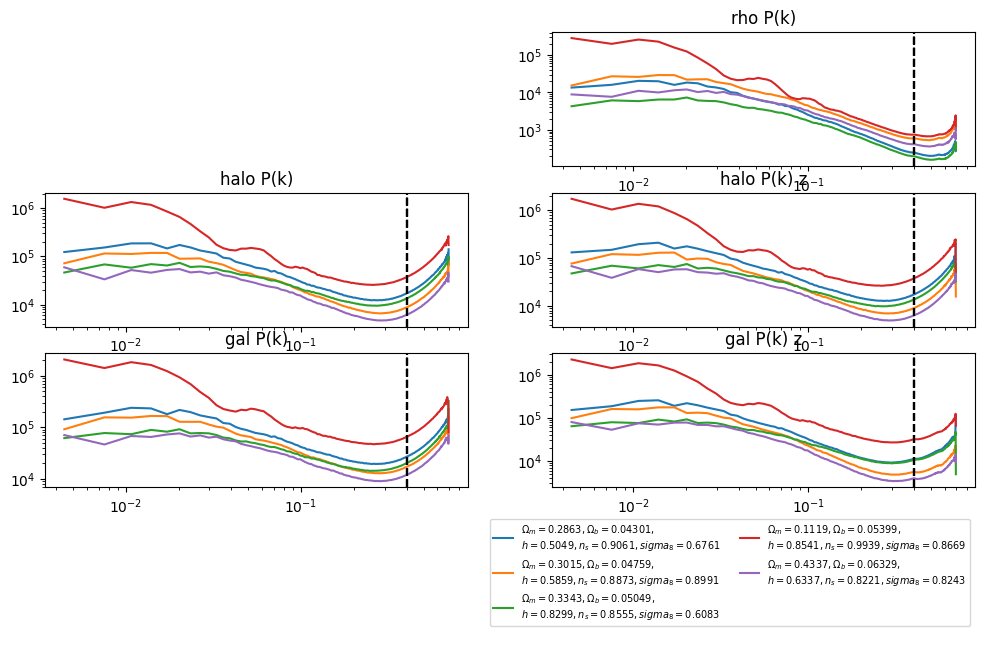

In [13]:
N = 256
L = 2000
k_nyq = np.pi * N / L
Nsamp = 5

fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(4,2)

axs = [fig.add_subplot(gs[i]) for i in range(6)]

for i, ind in enumerate(np.random.choice(len(rho_pk), Nsamp, replace=False)):
    label = f"$\Omega_m={cosmos[ind,0]}, \Omega_b={cosmos[ind,1]}, $\n"
    label += f"$h={cosmos[ind,2]}, n_s={cosmos[ind,3]}, sigma_8={cosmos[ind,4]}$"

    # survey Pk
    ax = axs[0]
    ax.axis('off')
    # ax.loglog(k_sur, survey_pk[ind], label=label)
    # ax.axvline(k_nyq, ls='--', c='k')
    # ax.set_title('survey P(k)')

    # rho Pk
    ax = axs[1]
    ax.loglog(k, rho_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('rho P(k)')

    # halo Pk
    ax = axs[2]
    ax.loglog(k, halo_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('halo P(k)')

    # haloz Pk
    ax = axs[3]
    ax.loglog(k, haloz_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('halo P(k) z')

    # gal Pk
    ax = axs[4]
    ax.loglog(k, gal_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('gal P(k)')

    # galz Pk
    ax = axs[5]
    ax.loglog(k, galz_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('gal P(k) z')
    h, l = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[7:])
ax.axis('off')
ax.legend(h, l, fontsize=7, ncol=2);

### Inference

In [14]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
device='cpu'

def run_inference(x, theta):
    loader = NumpyLoader(x=x, theta=theta)

    # define a prior
    prior = ili.utils.Uniform(
        low=theta.min(axis=0),
        high=theta.max(axis=0),
        device=device)

    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_lampe(model='nsf', hidden_features=50, num_transforms=5),
        # ili.utils.load_nde_lampe(model='gf', hidden_features=50, num_transforms=5)
    ]

    # define training arguments
    train_args = {
        'training_batch_size': 32,
        'learning_rate': 1e-4
    }

    # initialize the trainer
    runner = InferenceRunner.load(
        backend='lampe',
        engine='NPE',
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args
    )

    # train the model
    posterior_ensemble, summaries = runner(loader=loader)

    return posterior_ensemble, summaries

/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
test_frac = 0.1
np.random.seed(42)
in_test = np.random.rand(len(cosmos)) < test_frac

In [16]:
def log_and_mask(x):
    x = np.log10(x)
    mask = np.any(np.isnan(x), axis=0)
    mask *= np.any(np.isinf(x), axis=0)
    x = x[:,~mask]
    return x

rho_pk, halo_pk, haloz_pk, gal_pk, galz_pk = map(
    log_and_mask,
    [rho_pk, halo_pk, haloz_pk, gal_pk, galz_pk]
)
# rho_pk = log_and_mask(rho_pk)
# survey_pk = log_and_mask(survey_pk)

In [17]:
def mask_inf(x):
    mask = np.any(np.isnan(x), axis=0)
    mask *= np.any(np.isinf(x), axis=0)
    return x[:,~mask]

rho_pk, halo_pk, haloz_pk, gal_pk, galz_pk = map(
    mask_inf,
    [rho_pk, halo_pk, haloz_pk, gal_pk, galz_pk]
)
# rho_pk = mask_inf(rho_pk)
# survey_pk = mask_inf(survey_pk)

In [19]:
# rho_pk = rho_pk[:,:-1]
gal_pk, gal_pk.shape

(array([[5.9151069 , 6.00144564, 5.93854311, ..., 5.58511906, 5.78246579,
         5.21416169],
        [5.03581563, 5.13324474, 5.24956044, ..., 5.11622795, 5.11627953,
         5.01179611],
        [5.68371987, 5.91268625, 5.7706932 , ..., 5.37134121, 5.43231984,
         5.42393057],
        ...,
        [4.74485135, 5.15747952, 5.15917733, ..., 5.0675022 , 4.96094821,
         4.93019566],
        [5.77023711, 5.58289404, 5.66736215, ..., 5.59903466, 5.25893998,
         5.40074978],
        [4.94845249, 5.05117238, 4.95942196, ..., 4.92469826, 4.81135025,
         4.8625746 ]]),
 (653, 221))

In [24]:
k[:221]

array([0.00444982, 0.00753956, 0.01072395, 0.0139183 , 0.0171755 ,
       0.02023943, 0.02338358, 0.02654113, 0.02972681, 0.03288112,
       0.03598316, 0.0391393 , 0.04235199, 0.04548427, 0.04860395,
       0.05173815, 0.05487882, 0.05802715, 0.06118348, 0.06434086,
       0.06747504, 0.07059748, 0.07375668, 0.07689325, 0.08003288,
       0.08319956, 0.08635978, 0.08948826, 0.09261768, 0.09574034,
       0.09889449, 0.10204689, 0.10519697, 0.10834549, 0.11148501,
       0.114631  , 0.11775708, 0.12089553, 0.12404283, 0.12717461,
       0.13031671, 0.13346287, 0.13662117, 0.13977648, 0.14291831,
       0.14604381, 0.14917249, 0.15231913, 0.15546396, 0.15860841,
       0.16175938, 0.16490841, 0.16805882, 0.17118502, 0.17432391,
       0.17747058, 0.18059585, 0.18373835, 0.18688239, 0.1900327 ,
       0.19317699, 0.19630701, 0.19946323, 0.20260366, 0.20574582,
       0.20889071, 0.21202003, 0.21517128, 0.21831793, 0.22144981,
       0.22458172, 0.22772071, 0.23088172, 0.23403221, 0.23717

In [21]:
print('rho')
prho, srho = run_inference(rho_pk, cosmos)

print('halo')
phalo, shalo = run_inference(halo_pk, cosmos)

print('haloz')
phaloz, shaloz = run_inference(haloz_pk, cosmos)

print('gal')
pgal, sgal = run_inference(gal_pk, cosmos)

print('galz')
pgalz, sgalz = run_inference(galz_pk, cosmos)

# print('survey')
# psurvey, ssurvey = run_inference(survey_pk, cosmos)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


rho


369 epochs [02:22,  2.58 epochs/s, loss=-14.4, loss_val=-12.9]
INFO:root:It took 142.89621305465698 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


halo


303 epochs [01:57,  2.58 epochs/s, loss=-13.1, loss_val=-12]  
INFO:root:It took 117.44201326370239 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


haloz


421 epochs [02:45,  2.55 epochs/s, loss=-13.5, loss_val=-12.5]
INFO:root:It took 165.3418984413147 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


gal


288 epochs [01:51,  2.58 epochs/s, loss=-12.3, loss_val=-10.9]
INFO:root:It took 111.69029998779297 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


galz


323 epochs [02:04,  2.59 epochs/s, loss=-15, loss_val=-13.7]  
INFO:root:It took 124.79137229919434 seconds to train models.


INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1874it [00:00, 14057.95it/s]
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1764it [00:00, 8755.73it/s]                         
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1870it [00:00, 14365.95it/s]


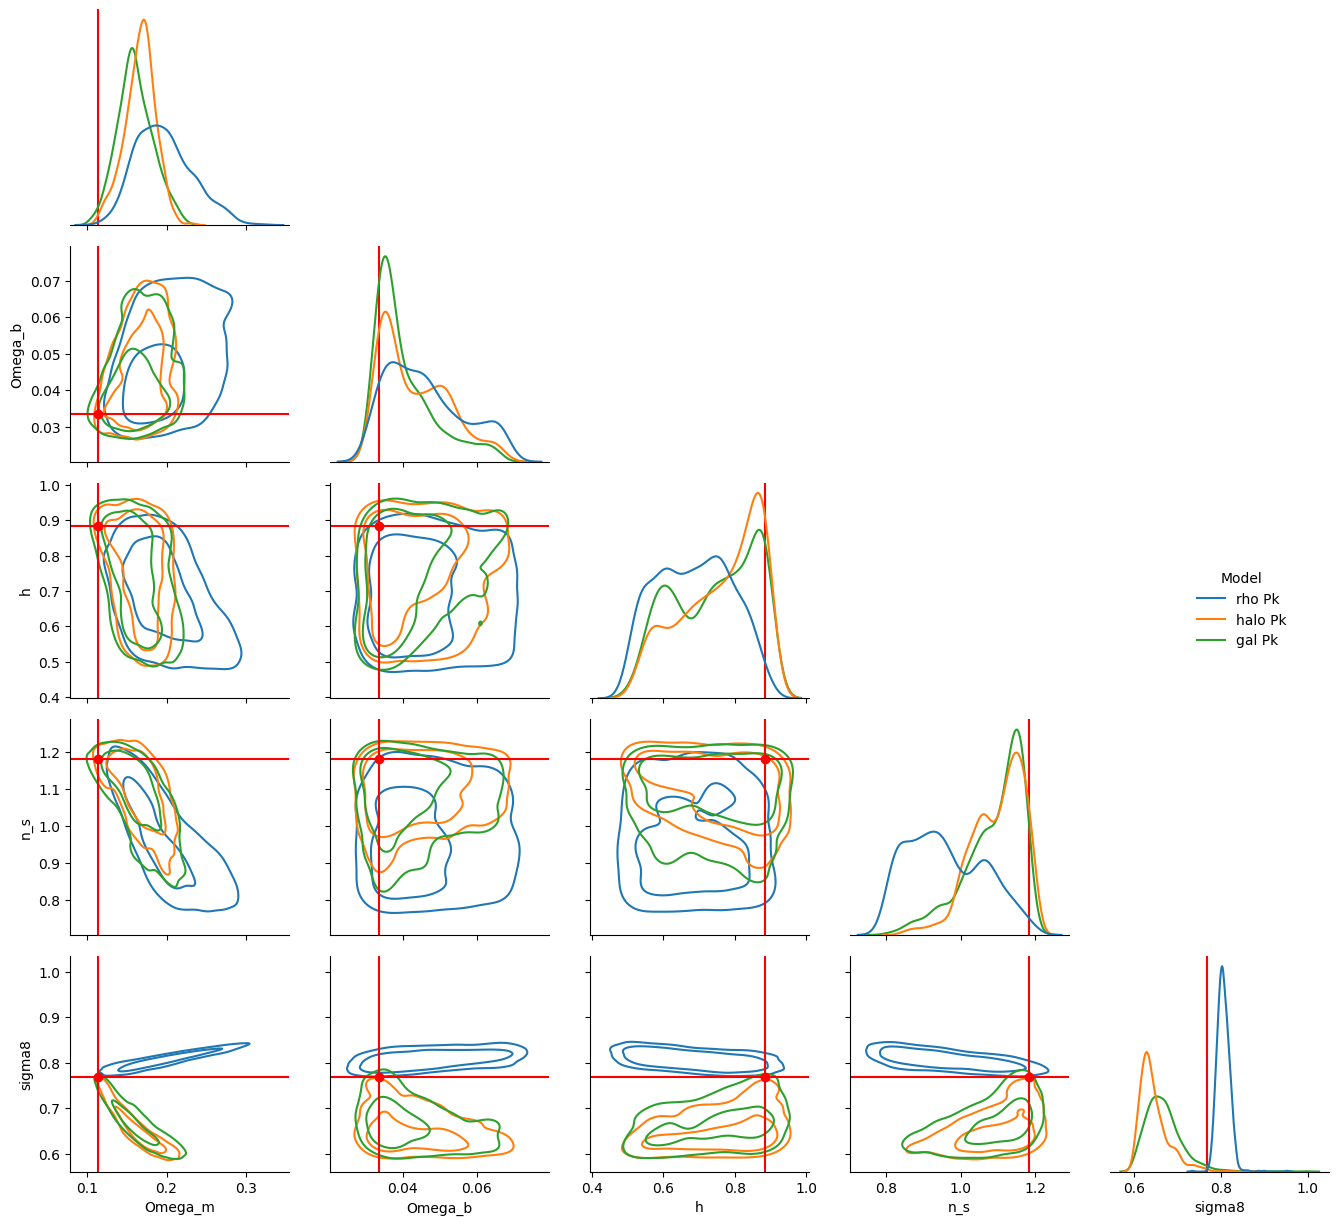

In [25]:
ind = np.random.choice(np.argwhere(in_test).flatten())
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)
fig = metric(
    posterior=prho,
    x_obs=rho_pk[ind], theta_fid=cosmos[ind],
    name='rho Pk'
)
fig = metric(
    posterior=phalo,
    x_obs=halo_pk[ind], theta_fid=cosmos[ind],
    grid=fig,
    name='halo Pk'
)
# fig = metric(
#     posterior=phaloz,
#     x_obs=haloz_pk[ind], theta_fid=cosmos[ind],
#     grid=fig,
#     name='halo Pk z'
# )
fig = metric(
    posterior=pgal,
    x_obs=gal_pk[ind], theta_fid=cosmos[ind],
    grid=fig,
    name='gal Pk'
)
# fig = metric(
#     posterior=pgalz,
#     x_obs=galz_pk[ind], theta_fid=cosmos[ind],
#     grid=fig,
#     name='gal Pk z'
# )

INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples: 1065it [00:00, 7509.10it/s]             
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1534it [00:00, 4077.15it/s]                         


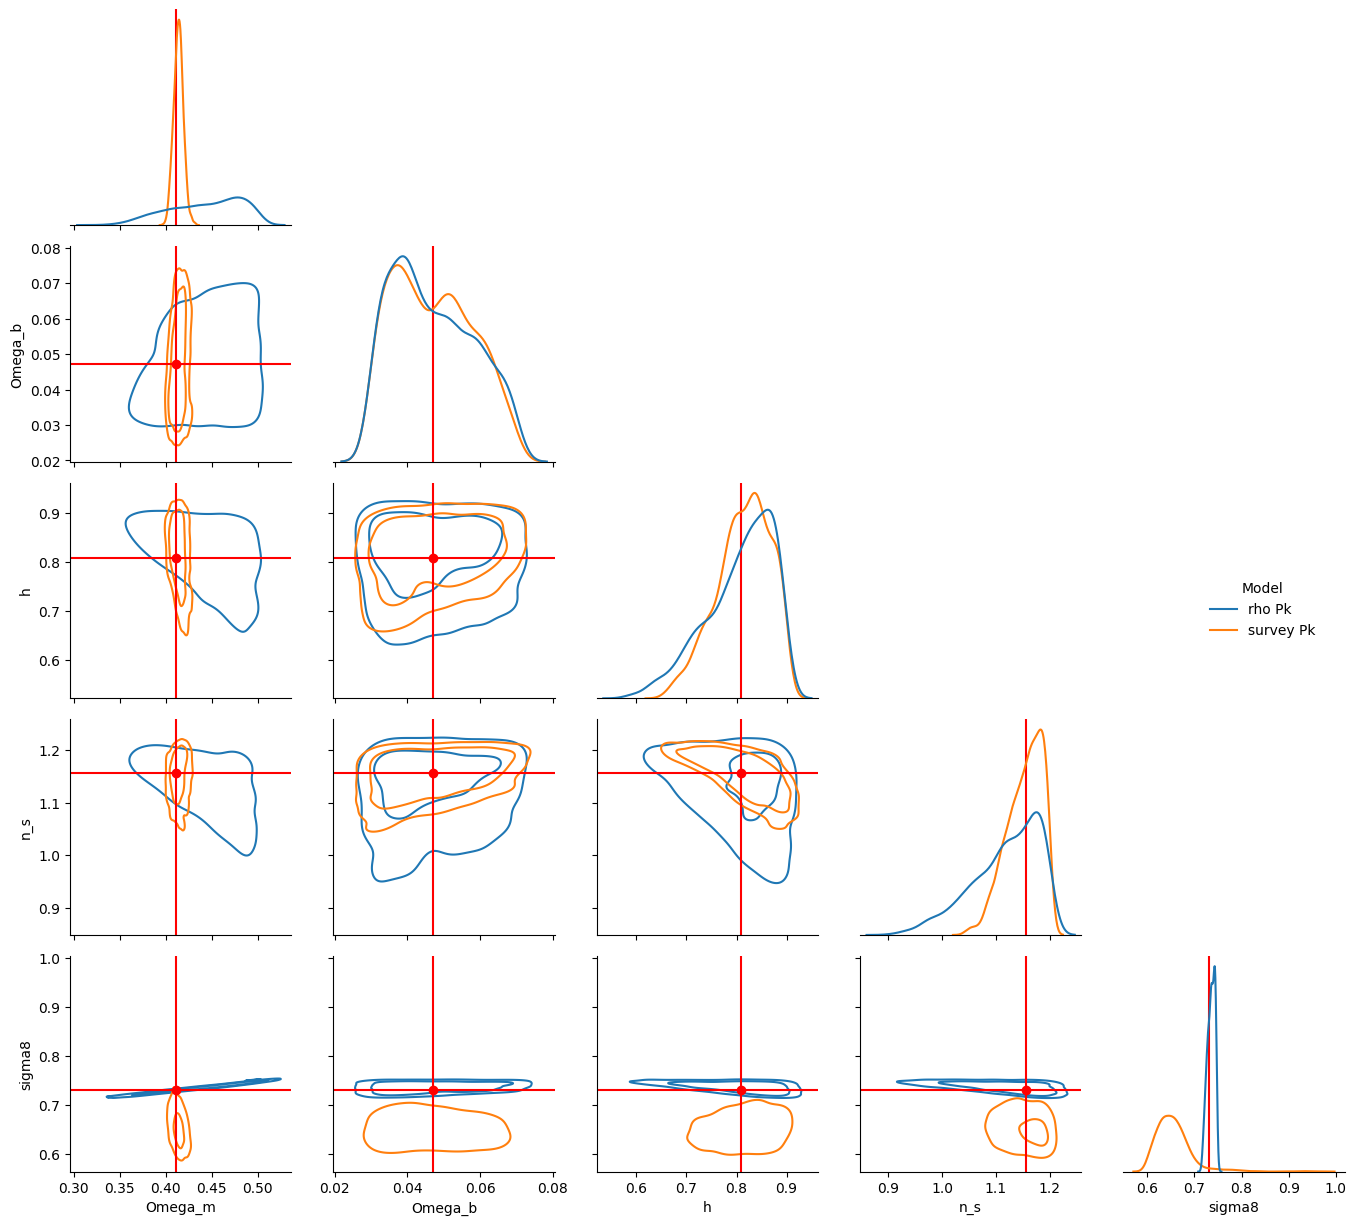

In [46]:
ind = np.random.choice(np.argwhere(in_test).flatten())
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)
fig = metric(
    posterior=prho,
    x_obs=rho_pk[ind][:-1], theta_fid=cosmos[ind],
    name='rho Pk'
)
fig = metric(
    posterior=psurvey,
    x_obs=survey_pk[ind], theta_fid=cosmos[ind],
    grid=fig,
    name='survey Pk'
)